In [14]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms
from sklearn import metrics
from PIL import Image
from IPython.display import Image 



In [15]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [16]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [18]:
batch_size = 10

In [19]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)     
        
    def get_imgs(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x

    

    

In [20]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")

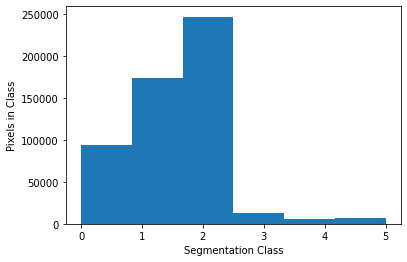

In [52]:
distn = dsetCE.label_imgs.clone().detach().flatten().int()
distn = np.asarray(distn.cpu())
plt.hist(distn, 6)
plt.xlabel("Segmentation Class")
plt.ylabel("Pixels in Class")
plt.savefig("pixeldistn.png", bbox_inches='tight')

In [21]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

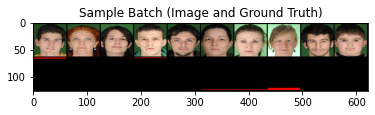

In [7]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(train_loader_CE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [22]:
# Cellular automata class
class GNCAModel(nn.Module):

    def __init__(self, channel_n, alpha_channel,
                 fire_rate=0.5, calibration=1.0, device=torch.device("cpu")):
        super(GNCAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fire_rate = fire_rate
        self.to(self.device)
        
        self.conv1 = nn.Conv2d(45, 36, kernel_size=3, padding=1)
        self.conv1a = nn.Conv2d(36,24, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(24, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        self.pre_weight1 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight2 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight3 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        self.pre_weight4 = nn.Conv2d(9, 9, kernel_size=3, padding=1)
        
    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            #conv_weights = torch.from_numpy(weight.astype(np.float32)).to(dev)
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 sobel operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalise these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with the 4 of these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)
        # Max pool of x
        y5 = self.pool(x)
        # Concatenate: x (6 channels), 4 sobel filters (6 channels each), max pool (6 channels) = 36 total
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y


    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach()[:,3:9,:])
                b1 = self.pre_weight1(x)
                b2 = self.pre_weight2(x)
                b3 = self.pre_weight3(x)
                b4 = self.pre_weight4(x)
                
                b = torch.cat((x, b1, b2, b3, b4), dim=1)
                bb = self.conv3(self.conv2((self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = bb*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b1 = self.pre_weight1(x)
                b2 = self.pre_weight2(x)
                b3 = self.pre_weight3(x)
                b4 = self.pre_weight4(x)
                
                b = torch.cat((x, b1, b2, b3, b4), dim=1)
                bb = self.conv3(self.conv2((self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = bb*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [23]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0014, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8, 9, 8.8]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
#loss = FocalLoss()
loss_mse = []
loss_ce = []
history = []
epochs = 200

batch_size=10

In [12]:
# Print number of model parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

19780


In [112]:
mask1 = torch.zeros(1,6,55,55).to(dev)
mask2 = torch.zeros(1,6,55,55).to(dev)
k = mask1.shape[2]
for i in range(k):
    for j in range(k):
        mask1[:,:,i,j] = (i + j + 1) % 2
        mask2[:,:,i,j] = (i + j) % 2

In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [ ]:
from array2gif import write_gif
eh = [(max_rgb(epoch_history[i])[1]*255).cpu().detach().numpy() for i in range(len(epoch_history))]
#eh = [(max_rgb(epoch_history[i][0])*255).cpu().detach().numpy() for i in range(len(epoch_history))]

write_gif(eh, 'final.gif', fps=1)
#eh[0].shape
#torch.stack(epoch_history)[0].shape

Loss = tensor(1.7867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


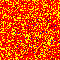

Learning rate:  0.0008
Loss = tensor(1.7865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


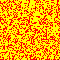

Learning rate:  0.0008
Loss = tensor(1.7723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


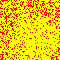

Learning rate:  0.0008
Loss = tensor(1.7385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


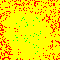

Learning rate:  0.0008
Loss = tensor(1.7217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


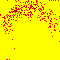

Learning rate:  0.0008
Loss = tensor(1.7012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


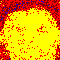

Learning rate:  0.0008
Loss = tensor(1.6859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


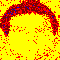

Learning rate:  0.0008
Loss = tensor(1.6696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


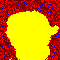

Learning rate:  0.0008
Loss = tensor(1.6279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6274, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


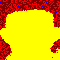

Learning rate:  0.0008
Loss = tensor(1.6304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


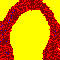

Learning rate:  0.0008
Loss = tensor(1.6151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


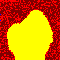

Learning rate:  0.0008
Loss = tensor(1.6238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


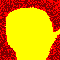

Learning rate:  0.0008
Loss = tensor(1.6047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


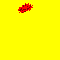

Learning rate:  0.0008
Loss = tensor(1.6046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


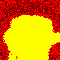

Learning rate:  0.0008
Loss = tensor(1.6162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


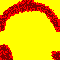

Learning rate:  0.0008
Loss = tensor(1.6098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


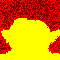

Learning rate:  0.0008
Loss = tensor(1.5882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


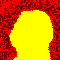

Learning rate:  0.0008
Loss = tensor(1.5845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


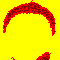

Learning rate:  0.0008
Loss = tensor(1.6209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


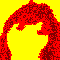

Learning rate:  0.0008
Loss = tensor(1.5875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


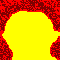

Learning rate:  0.0008
Loss = tensor(1.6099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


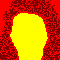

Learning rate:  0.0008
Loss = tensor(1.5769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


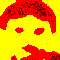

Learning rate:  0.0008
Loss = tensor(1.5781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


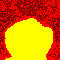

Learning rate:  0.0008
Loss = tensor(1.6027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


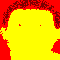

Learning rate:  0.0008
Loss = tensor(1.5935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


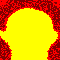

Learning rate:  0.0008
Loss = tensor(1.5868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


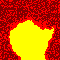

Learning rate:  0.0008
Loss = tensor(1.5760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


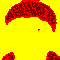

Learning rate:  0.0008
Loss = tensor(1.5713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


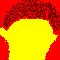

Learning rate:  0.0008
Loss = tensor(1.5723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


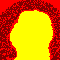

Learning rate:  0.0008
Loss = tensor(1.5885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


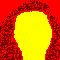

Learning rate:  0.0008
Loss = tensor(1.6061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


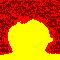

Learning rate:  0.0008
Loss = tensor(1.6373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


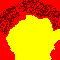

Learning rate:  0.0008
Loss = tensor(1.6099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


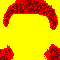

Learning rate:  0.0008
Loss = tensor(1.6080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


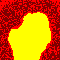

Learning rate:  0.0008
Loss = tensor(1.5718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


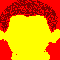

Learning rate:  0.0008
Loss = tensor(1.5545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


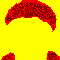

Learning rate:  0.0008
Loss = tensor(1.5752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


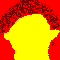

Learning rate:  0.0008
Loss = tensor(1.5874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


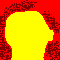

Learning rate:  0.0008
Loss = tensor(1.5803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


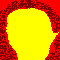

Learning rate:  0.0008
Loss = tensor(1.5549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


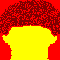

Learning rate:  0.0008
Loss = tensor(1.5554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


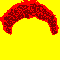

Learning rate:  0.0008
Loss = tensor(1.5831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


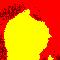

Learning rate:  0.0008
Loss = tensor(1.6250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


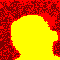

Learning rate:  0.0008
Loss = tensor(1.5762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


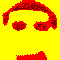

Learning rate:  0.0008
Loss = tensor(1.5429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


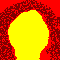

Learning rate:  0.0008
Loss = tensor(1.6141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


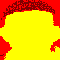

Learning rate:  0.0008
Loss = tensor(1.5394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


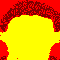

Learning rate:  0.0008
Loss = tensor(1.5803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


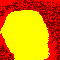

Learning rate:  0.0008
Loss = tensor(1.5512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


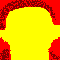

Learning rate:  0.0008
Loss = tensor(1.5644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


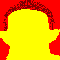

Learning rate:  0.0008
Loss = tensor(1.5494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


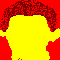

Learning rate:  0.0008
Loss = tensor(1.5603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


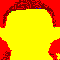

Learning rate:  0.0008
Loss = tensor(1.5482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


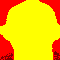

Learning rate:  0.0008
Loss = tensor(1.5926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


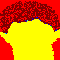

Learning rate:  0.0008
Loss = tensor(1.5554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


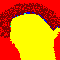

Learning rate:  0.0008
Loss = tensor(1.5512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


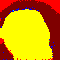

Learning rate:  0.0008
Loss = tensor(1.5526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


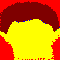

Learning rate:  0.0008
Loss = tensor(1.5419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


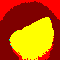

Learning rate:  0.0008
Loss = tensor(1.5537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


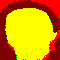

Learning rate:  0.0008
Loss = tensor(1.5315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


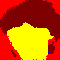

Learning rate:  0.0008
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


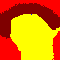

Learning rate:  0.0008
Loss = tensor(1.5670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


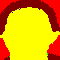

Learning rate:  0.0008
Loss = tensor(1.5116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


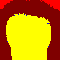

Learning rate:  0.0008
Loss = tensor(1.5156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


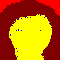

Learning rate:  0.0008
Loss = tensor(1.5200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


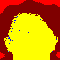

Learning rate:  0.0008
Loss = tensor(1.5137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


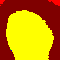

Learning rate:  0.0008
Loss = tensor(1.5296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


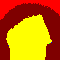

Learning rate:  0.0008
Loss = tensor(1.5229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


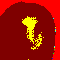

Learning rate:  0.0008
Loss = tensor(1.5052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


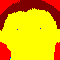

Learning rate:  0.0008
Loss = tensor(1.5346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


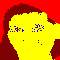

Learning rate:  0.0008
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


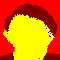

Learning rate:  0.0008
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


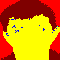

Learning rate:  0.0008
Loss = tensor(1.5226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


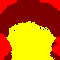

Learning rate:  0.0008
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


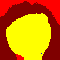

Learning rate:  0.0008
Loss = tensor(1.5228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


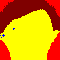

Learning rate:  0.0008
Loss = tensor(1.5147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


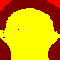

Learning rate:  0.0008
Loss = tensor(1.5248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


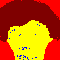

Learning rate:  0.0008
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


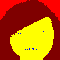

Learning rate:  0.0008
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


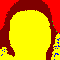

Learning rate:  0.0008
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


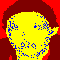

Learning rate:  0.0008
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


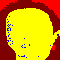

Learning rate:  0.0008
Loss = tensor(1.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


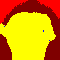

Learning rate:  0.0008
Loss = tensor(1.5083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


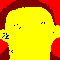

Learning rate:  0.0008
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


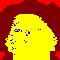

Learning rate:  0.0008
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


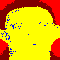

Learning rate:  0.0008
Loss = tensor(1.5088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


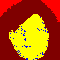

Learning rate:  0.0008
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


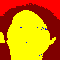

Learning rate:  0.0008
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


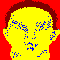

Learning rate:  0.0008
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


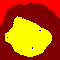

Learning rate:  0.0008
Loss = tensor(1.4981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


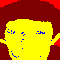

Learning rate:  0.0008
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


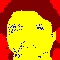

Learning rate:  0.0004
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


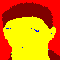

Learning rate:  0.0004
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


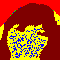

Learning rate:  0.0004
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


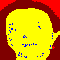

Learning rate:  0.0004
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


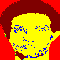

Learning rate:  0.0004
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


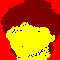

Learning rate:  0.0004
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


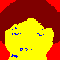

Learning rate:  0.0004
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


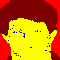

Learning rate:  0.0004
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


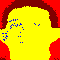

Learning rate:  0.0004
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


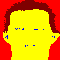

Learning rate:  0.0004
Loss = tensor(1.5087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


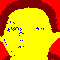

Learning rate:  0.0004
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


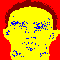

Learning rate:  0.0004
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


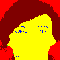

Learning rate:  0.0004
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


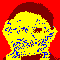

Learning rate:  0.0004
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


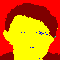

Learning rate:  0.0004
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


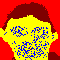

Learning rate:  0.0004
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


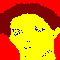

Learning rate:  0.0004
Loss = tensor(1.4805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


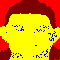

Learning rate:  0.0004
Loss = tensor(1.4938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


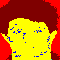

Learning rate:  0.0004
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


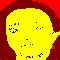

Learning rate:  0.0004
Loss = tensor(1.5321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


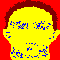

Learning rate:  0.0004
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


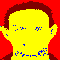

Learning rate:  0.0004
Loss = tensor(1.4894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


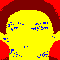

Learning rate:  0.0004
Loss = tensor(1.5129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


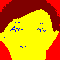

Learning rate:  0.0004
Loss = tensor(1.5064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


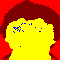

Learning rate:  0.0004
Loss = tensor(1.4974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


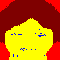

Learning rate:  0.0004
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


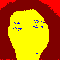

Learning rate:  0.0004
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


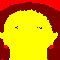

Learning rate:  0.0004
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


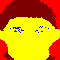

Learning rate:  0.0004
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


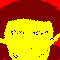

Learning rate:  0.0004
Loss = tensor(1.5033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


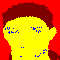

Learning rate:  0.0004
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


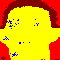

Learning rate:  0.0004
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


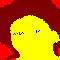

Learning rate:  0.0004
Loss = tensor(1.4984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


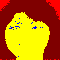

Learning rate:  0.0004
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


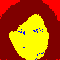

Learning rate:  0.0004
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


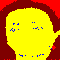

Learning rate:  0.0004
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


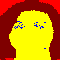

Learning rate:  0.0004
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


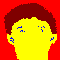

Learning rate:  0.0004
Loss = tensor(1.4930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


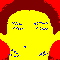

Learning rate:  0.0004
Loss = tensor(1.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


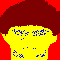

Learning rate:  0.0004
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


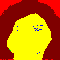

Learning rate:  0.0004
Loss = tensor(1.4990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


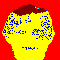

Learning rate:  0.0004
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


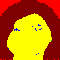

Learning rate:  0.0004
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


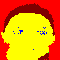

Learning rate:  0.0004
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


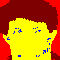

Learning rate:  0.0004
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


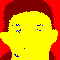

Learning rate:  0.0004
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


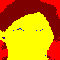

Learning rate:  0.0004
Loss = tensor(1.5093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


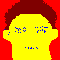

Learning rate:  0.0004
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


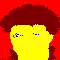

Learning rate:  0.0004
Loss = tensor(1.4917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


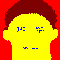

Learning rate:  0.0004
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


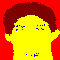

Learning rate:  0.0004
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


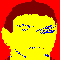

Learning rate:  0.0004
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


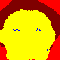

Learning rate:  0.0004
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


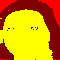

Learning rate:  0.0004
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


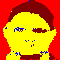

Learning rate:  0.0004
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


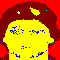

Learning rate:  0.0004
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


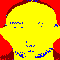

Learning rate:  0.0004
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


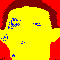

Learning rate:  0.0004
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


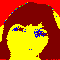

Learning rate:  0.0004
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


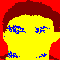

Learning rate:  0.0004
Loss = tensor(1.5151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


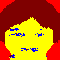

Learning rate:  0.0004
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


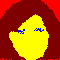

Learning rate:  0.0004
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


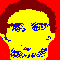

Learning rate:  0.0004
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


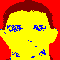

Learning rate:  0.0004
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


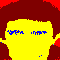

Learning rate:  0.0004
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


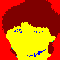

Learning rate:  0.0004
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


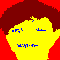

Learning rate:  0.0004
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


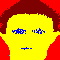

Learning rate:  0.0004
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


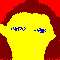

Learning rate:  0.0004
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


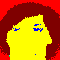

Learning rate:  0.0004
Loss = tensor(1.4731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


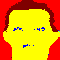

Learning rate:  0.0004
Loss = tensor(1.5045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


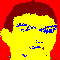

Learning rate:  0.0004
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


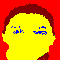

Learning rate:  0.0004
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


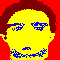

Learning rate:  0.0004
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


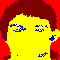

Learning rate:  0.0004
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


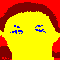

Learning rate:  0.0004
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


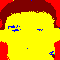

Learning rate:  0.0004
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


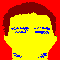

Learning rate:  0.0004
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


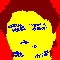

Learning rate:  0.0004
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


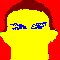

Learning rate:  0.0004
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


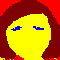

Learning rate:  0.0004
Loss = tensor(1.4677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


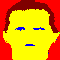

Learning rate:  0.0004
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


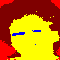

Learning rate:  0.0004
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


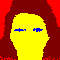

Learning rate:  0.0004
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


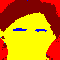

Learning rate:  0.0004
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


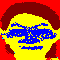

Learning rate:  0.0004
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


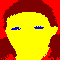

Learning rate:  0.0004
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


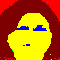

Learning rate:  0.0004
Loss = tensor(1.5363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


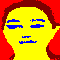

Learning rate:  0.0004
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


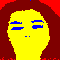

Learning rate:  0.0004
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


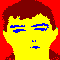

Learning rate:  0.0002
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


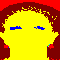

Learning rate:  0.0002
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


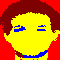

Learning rate:  0.0002
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


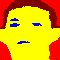

Learning rate:  0.0002
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


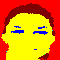

Learning rate:  0.0002
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


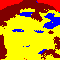

Learning rate:  0.0002
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


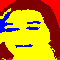

Learning rate:  0.0002
Loss = tensor(1.4956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


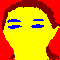

Learning rate:  0.0002
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


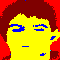

Learning rate:  0.0002
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


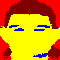

Learning rate:  0.0002
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


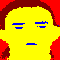

Learning rate:  0.0002
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


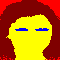

Learning rate:  0.0002
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


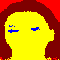

Learning rate:  0.0002
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


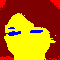

Learning rate:  0.0002
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


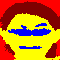

Learning rate:  0.0002
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


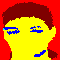

Learning rate:  0.0002
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


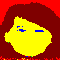

Learning rate:  0.0002
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


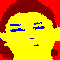

Learning rate:  0.0002
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


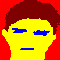

Learning rate:  0.0002
Loss = tensor(1.4672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


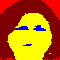

Learning rate:  0.0002
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


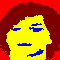

Learning rate:  0.0002
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


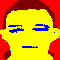

Learning rate:  0.0002
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


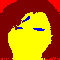

Learning rate:  0.0002
Loss = tensor(1.4572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


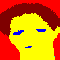

Learning rate:  0.0002
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


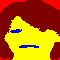

Learning rate:  0.0002
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


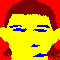

Learning rate:  0.0002
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


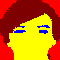

Learning rate:  0.0002
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


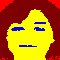

Learning rate:  0.0002
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


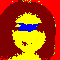

Learning rate:  0.0002
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


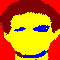

Learning rate:  0.0002
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


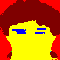

Learning rate:  0.0002
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


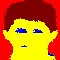

Learning rate:  0.0002
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


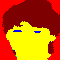

Learning rate:  0.0002
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


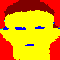

Learning rate:  0.0002
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


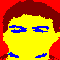

Learning rate:  0.0002
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


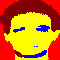

Learning rate:  0.0002
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


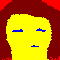

Learning rate:  0.0002
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


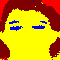

Learning rate:  0.0002
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


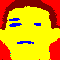

Learning rate:  0.0002
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


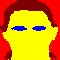

Learning rate:  0.0002
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


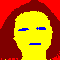

Learning rate:  0.0002
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


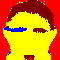

Learning rate:  0.0002
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


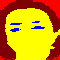

Learning rate:  0.0002
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


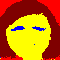

Learning rate:  0.0002
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


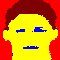

Learning rate:  0.0002
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


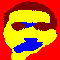

Learning rate:  0.0002
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


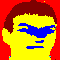

Learning rate:  0.0002
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


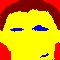

Learning rate:  0.0002
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


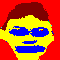

Learning rate:  0.0002
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


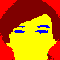

Learning rate:  0.0002
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


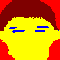

Learning rate:  0.0002
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


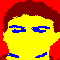

Learning rate:  0.0002
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


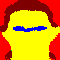

Learning rate:  0.0002
Loss = tensor(1.4395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


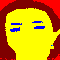

Learning rate:  0.0002
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


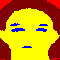

Learning rate:  0.0002
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


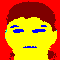

Learning rate:  0.0002
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


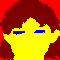

Learning rate:  0.0002
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


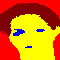

Learning rate:  0.0002
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


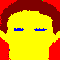

Learning rate:  0.0002
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


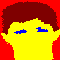

Learning rate:  0.0002
Loss = tensor(1.4854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


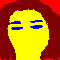

Learning rate:  0.0002
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


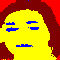

Learning rate:  0.0002
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


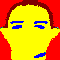

Learning rate:  0.0002
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


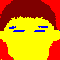

Learning rate:  0.0002
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


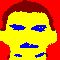

Learning rate:  0.0002
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


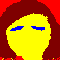

Learning rate:  0.0002
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


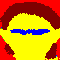

Learning rate:  0.0002
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


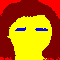

Learning rate:  0.0002
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


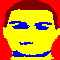

Learning rate:  0.0002
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


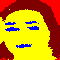

Learning rate:  0.0002
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


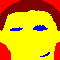

Learning rate:  0.0002
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


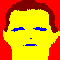

Learning rate:  0.0002
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


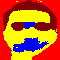

Learning rate:  0.0002
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


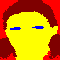

Learning rate:  0.0002
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


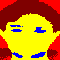

Learning rate:  0.0002
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


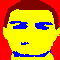

Learning rate:  0.0002
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


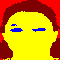

Learning rate:  0.0002
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


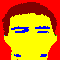

Learning rate:  0.0002
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


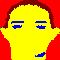

Learning rate:  0.0002
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


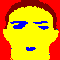

Learning rate:  0.0002
Loss = tensor(1.4651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


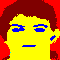

Learning rate:  0.0002
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


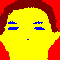

Learning rate:  0.0002
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


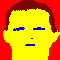

Learning rate:  0.0002
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


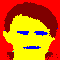

Learning rate:  0.0002
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


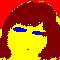

Learning rate:  0.0002
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


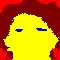

Learning rate:  0.0002
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


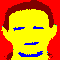

Learning rate:  0.0002
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


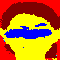

Learning rate:  0.0002
Loss = tensor(1.5160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


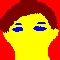

Learning rate:  0.0002
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


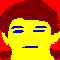

Learning rate:  0.0002
Loss = tensor(1.4739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


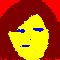

Learning rate:  0.0002
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


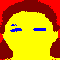

Learning rate:  0.0002
Loss = tensor(1.4526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


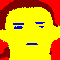

Learning rate:  0.0002
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


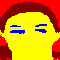

Learning rate:  0.0002
Loss = tensor(1.4386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


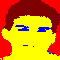

Learning rate:  0.0002
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


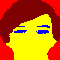

Learning rate:  0.0002
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


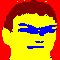

Learning rate:  0.0002
Loss = tensor(1.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


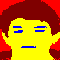

Learning rate:  0.0002
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


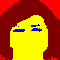

Learning rate:  0.0002
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


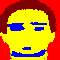

Learning rate:  0.0002
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


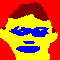

Learning rate:  0.0002
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


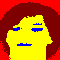

Learning rate:  0.0002
Loss = tensor(1.4607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


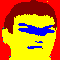

Learning rate:  0.0002
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


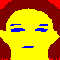

Learning rate:  0.0002
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


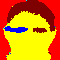

Learning rate:  0.0002
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


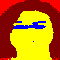

Learning rate:  0.0002
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


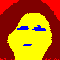

Learning rate:  0.0002
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


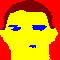

Learning rate:  0.0002
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


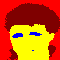

Learning rate:  0.0002
Loss = tensor(1.4478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


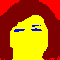

Learning rate:  0.0002
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


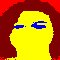

Learning rate:  0.0002
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


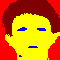

Learning rate:  0.0002
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


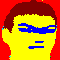

Learning rate:  0.0002
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


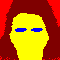

Learning rate:  0.0002
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


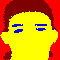

Learning rate:  0.0002
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


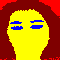

Learning rate:  0.0002
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


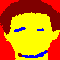

Learning rate:  0.0002
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


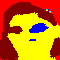

Learning rate:  0.0002
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


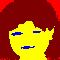

Learning rate:  0.0002
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


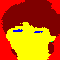

Learning rate:  0.0002
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


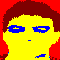

Learning rate:  0.0002
Loss = tensor(1.4433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


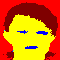

Learning rate:  0.0002
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


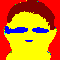

Learning rate:  0.0002
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


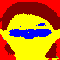

Learning rate:  0.0002
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


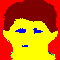

Learning rate:  0.0002
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


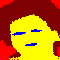

Learning rate:  0.0002
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


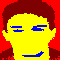

Learning rate:  0.0002
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


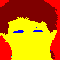

Learning rate:  0.0002
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


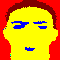

Learning rate:  0.0002
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


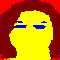

Learning rate:  0.0002
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


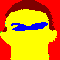

Learning rate:  0.0002
Loss = tensor(1.4567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


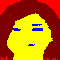

Learning rate:  0.0002
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


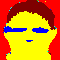

Learning rate:  0.0002
Loss = tensor(1.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


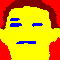

Learning rate:  0.0002
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


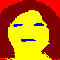

Learning rate:  0.0002
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


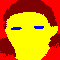

Learning rate:  0.0002
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


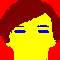

Learning rate:  0.0002
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


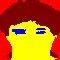

Learning rate:  0.0002
Loss = tensor(1.4433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


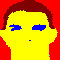

Learning rate:  0.0002
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


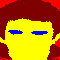

Learning rate:  0.0002
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


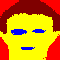

Learning rate:  0.0002
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


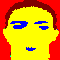

Learning rate:  0.0002
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


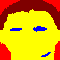

Learning rate:  0.0002
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


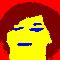

Learning rate:  0.0002
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


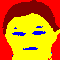

Learning rate:  0.0002
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


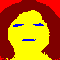

Learning rate:  0.0002
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


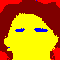

Learning rate:  0.0002
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


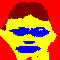

Learning rate:  0.0002
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


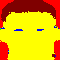

Learning rate:  0.0002
Loss = tensor(1.4420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


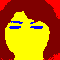

Learning rate:  0.0002
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


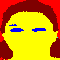

Learning rate:  0.0002
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


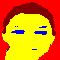

Learning rate:  0.0002
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


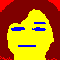

Learning rate:  0.0002
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


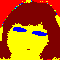

Learning rate:  0.0002
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


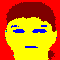

Learning rate:  0.0002
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


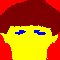

Learning rate:  0.0002
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


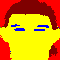

Learning rate:  0.0002
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


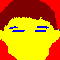

Learning rate:  0.0002
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


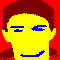

Learning rate:  0.0002
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


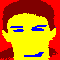

Learning rate:  0.0002
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


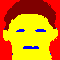

Learning rate:  0.0002
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


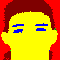

Learning rate:  0.0002
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


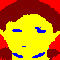

Learning rate:  0.0002
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


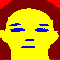

Learning rate:  0.0002
Loss = tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


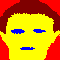

Learning rate:  0.0002
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


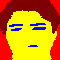

Learning rate:  0.0002
Loss = tensor(1.4623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


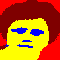

Learning rate:  0.0002
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


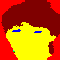

Learning rate:  0.0002
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


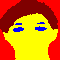

Learning rate:  0.0002
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


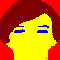

Learning rate:  0.0002
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


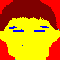

Learning rate:  0.0002
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


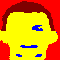

Learning rate:  0.0002
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


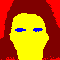

Learning rate:  0.0002
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


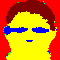

Learning rate:  0.0002
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


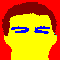

Learning rate:  0.0002
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


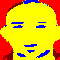

Learning rate:  0.0002
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


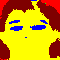

Learning rate:  0.0002
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


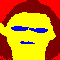

Learning rate:  0.0002
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


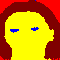

Learning rate:  0.0002
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


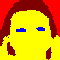

Learning rate:  0.0002
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


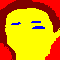

Learning rate:  0.0002
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


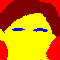

Learning rate:  0.0002
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


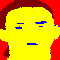

Learning rate:  0.0002
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


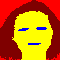

Learning rate:  0.0002
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


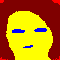

Learning rate:  0.0002
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


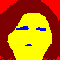

Learning rate:  0.0002
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


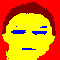

Learning rate:  0.0002
Loss = tensor(1.4917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


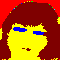

Learning rate:  0.0002
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


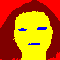

Learning rate:  0.0002
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


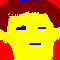

Learning rate:  0.0002
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


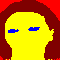

Learning rate:  0.0002
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


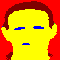

Learning rate:  0.0002
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


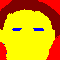

Learning rate:  0.0002
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


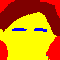

Learning rate:  0.0002
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


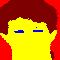

Learning rate:  0.0002
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


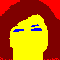

Learning rate:  0.0002
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


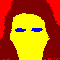

Learning rate:  0.0002
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


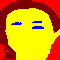

Learning rate:  0.0002
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


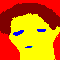

Learning rate:  0.0002
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


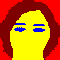

Learning rate:  0.0002
Loss = tensor(1.4486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


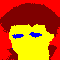

Learning rate:  0.0002
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


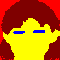

Learning rate:  0.0002
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


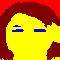

Learning rate:  0.0002
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


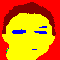

Learning rate:  0.0002
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


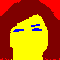

Learning rate:  0.0002
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


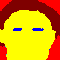

Learning rate:  0.0002
Loss = tensor(1.4402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


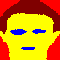

Learning rate:  0.0002
Loss = tensor(1.4424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


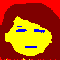

Learning rate:  0.0002
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


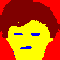

Learning rate:  0.0002
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


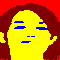

Learning rate:  0.0002
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


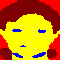

Learning rate:  0.0002
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


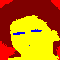

Learning rate:  0.0002
Loss = tensor(1.4438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


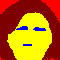

Learning rate:  0.0002
Loss = tensor(1.4435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


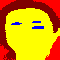

Learning rate:  0.0002
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


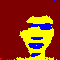

Learning rate:  0.0002
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


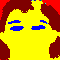

Learning rate:  0.0002
Loss = tensor(1.4434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


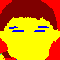

Learning rate:  0.0002
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


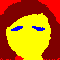

Learning rate:  0.0002
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


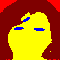

Learning rate:  0.0002
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


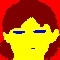

Learning rate:  0.0002
Loss = tensor(1.4405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


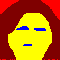

Learning rate:  0.0002
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


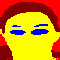

Learning rate:  0.0002
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


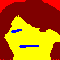

Learning rate:  0.0002
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


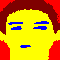

Learning rate:  0.0002
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


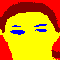

Learning rate:  0.0002
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


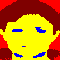

Learning rate:  0.0002
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


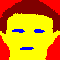

Learning rate:  0.0002
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


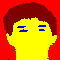

Learning rate:  0.0002
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


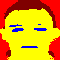

Learning rate:  0.0002
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


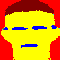

Learning rate:  0.0002
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


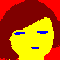

Learning rate:  0.0002
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


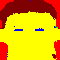

Learning rate:  0.0002
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


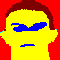

Learning rate:  0.0002
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


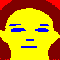

Learning rate:  0.0002
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


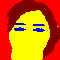

Learning rate:  0.0002
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


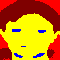

Learning rate:  0.0002
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


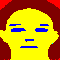

Learning rate:  0.0002
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


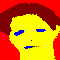

Learning rate:  0.0002
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


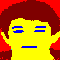

Learning rate:  0.0002
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


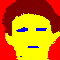

Learning rate:  0.0002
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


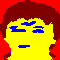

Learning rate:  0.0002
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


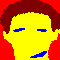

Learning rate:  0.0002
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


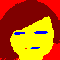

Learning rate:  0.0002
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


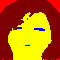

Learning rate:  0.0002
Loss = tensor(1.4356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


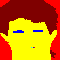

Learning rate:  0.0002
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


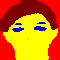

Learning rate:  0.0002
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


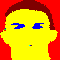

Learning rate:  0.0002
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


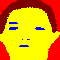

Learning rate:  0.0002
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


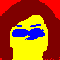

Learning rate:  0.0002
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


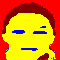

Learning rate:  0.0002
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


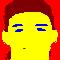

Learning rate:  0.0002
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


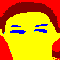

Learning rate:  0.0002
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


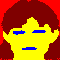

Learning rate:  0.0002
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


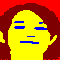

Learning rate:  0.0002
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


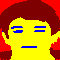

Learning rate:  0.0002
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


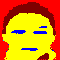

Learning rate:  0.0002
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


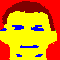

Learning rate:  0.0002
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


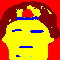

Learning rate:  0.0002
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


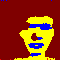

Learning rate:  0.0002
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


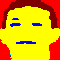

Learning rate:  0.0002
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


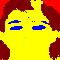

Learning rate:  0.0002
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


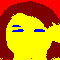

Learning rate:  0.0002
Loss = tensor(1.4623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


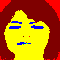

Learning rate:  0.0002
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


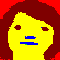

Learning rate:  0.0002
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


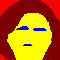

Learning rate:  0.0002
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


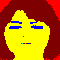

Learning rate:  0.0002
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


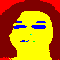

Learning rate:  0.0002
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


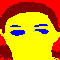

Learning rate:  0.0002
Loss = tensor(1.4599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


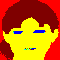

Learning rate:  0.0002
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


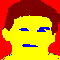

Learning rate:  0.0002
Loss = tensor(1.4551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


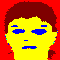

Learning rate:  0.0002
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


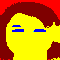

Learning rate:  0.0002
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4659, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


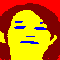

Learning rate:  0.0002
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


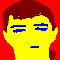

Learning rate:  0.0002
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


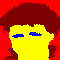

Learning rate:  0.0002
Loss = tensor(1.4363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


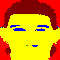

Learning rate:  0.0002
Loss = tensor(1.4478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


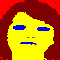

Learning rate:  0.0002
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


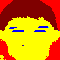

Learning rate:  0.0002
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


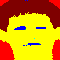

Learning rate:  0.0002
Loss = tensor(1.4470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


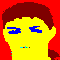

Learning rate:  0.0002
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


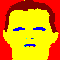

Learning rate:  0.0002
Loss = tensor(1.4628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


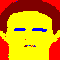

Learning rate:  0.0002
Loss = tensor(1.4535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


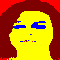

Learning rate:  0.0002
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


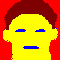

Learning rate:  0.0002
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


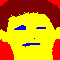

Learning rate:  0.0002
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


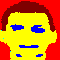

Learning rate:  0.0002
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


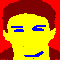

Learning rate:  0.0002
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


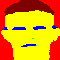

Learning rate:  0.0002
Loss = tensor(1.4473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


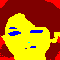

Learning rate:  0.0002
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


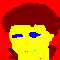

Learning rate:  0.0002
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


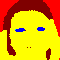

Learning rate:  0.0002
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


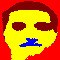

Learning rate:  0.0002
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


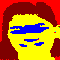

Learning rate:  0.0002
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


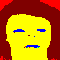

Learning rate:  0.0002
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


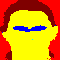

Learning rate:  0.0002
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


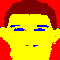

Learning rate:  0.0002
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


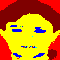

Learning rate:  0.0002
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


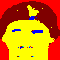

Learning rate:  0.0002
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


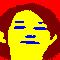

Learning rate:  0.0002
Loss = tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


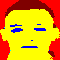

Learning rate:  0.0002
Loss = tensor(1.4964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


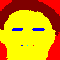

Learning rate:  0.0002
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


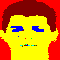

Learning rate:  0.0002
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


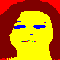

Learning rate:  0.0002
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


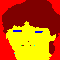

Learning rate:  0.0002
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


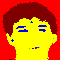

Learning rate:  0.0002
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


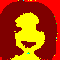

Learning rate:  0.0002
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


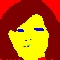

Learning rate:  0.0002
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


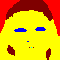

Learning rate:  0.0002
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


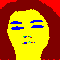

Learning rate:  0.0002
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


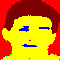

Learning rate:  0.0002
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


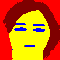

Learning rate:  0.0002
Loss = tensor(1.4651, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


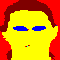

Learning rate:  0.0002
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


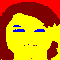

Learning rate:  0.0002
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


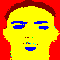

Learning rate:  0.0002
Loss = tensor(1.4604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


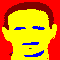

Learning rate:  0.0002
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4484, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


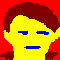

Learning rate:  0.0002
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


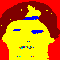

Learning rate:  0.0002
Loss = tensor(1.4565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


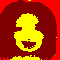

Learning rate:  0.0002
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


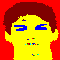

Learning rate:  0.0002
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


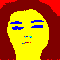

Learning rate:  0.0002
Loss = tensor(1.4598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


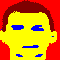

Learning rate:  0.0002
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


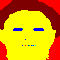

Learning rate:  0.0002
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


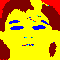

Learning rate:  0.0002
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


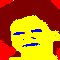

Learning rate:  0.0002
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


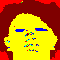

Learning rate:  0.0002
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


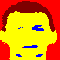

Learning rate:  0.0002
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


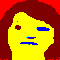

Learning rate:  0.0002
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


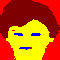

Learning rate:  0.0002
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


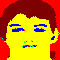

Learning rate:  0.0002
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


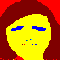

Learning rate:  0.0002
Loss = tensor(1.4449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


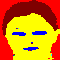

Learning rate:  0.0002
Loss = tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


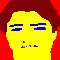

Learning rate:  0.0002
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


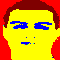

Learning rate:  0.0002
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


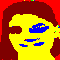

Learning rate:  0.0002
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


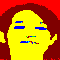

Learning rate:  0.0002
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


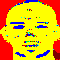

Learning rate:  0.0002
Loss = tensor(1.4447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


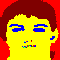

Learning rate:  0.0002
Loss = tensor(1.4558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


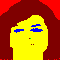

Learning rate:  0.0002
Loss = tensor(1.4532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


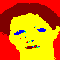

Learning rate:  0.0002
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


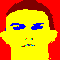

Learning rate:  0.0002
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


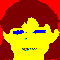

Learning rate:  0.0002
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


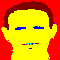

Learning rate:  0.0002
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


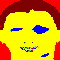

Learning rate:  0.0002
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


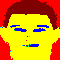

Learning rate:  0.0002
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


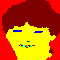

Learning rate:  0.0002
Loss = tensor(1.4327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


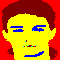

Learning rate:  0.0002
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


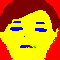

Learning rate:  0.0002
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


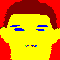

Learning rate:  0.0002
Loss = tensor(1.4384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


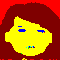

Learning rate:  0.0002
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


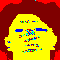

Learning rate:  0.0002
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


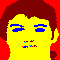

Learning rate:  0.0002
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


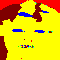

Learning rate:  0.0002
Loss = tensor(1.4739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


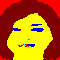

Learning rate:  0.0002
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


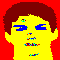

Learning rate:  0.0002
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


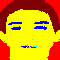

Learning rate:  0.0002
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


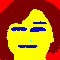

Learning rate:  0.0002
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


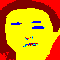

Learning rate:  0.0002
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


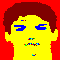

Learning rate:  0.0002
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


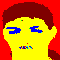

Learning rate:  0.0002
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


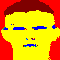

Learning rate:  0.0002
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [24]:
for epoch in range(epochs):
    i = 0
    last = False
    
    if epoch == epochs-1:
        last = True
        
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
        
    scheduler.step()

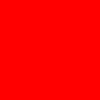

In [26]:
from IPython.display import display, Image
Image('final.gif')

In [26]:
torch.save(model, 'modelcollab1.pth')

torch.Size([70, 70, 4])


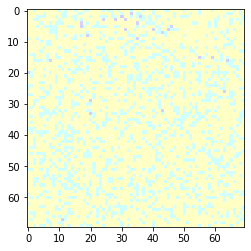

In [94]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [107]:
# Save final iterations as gif

epoch_new = [ts(max_rgb(i)[0]) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

# DICE Score
def dice(pred, truth, epsilon=1e-6):
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)
    
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    d5 = 2*TP+FN+FP
    if d5 == 0:
        d5 = epsilon
    dice = 2*TP/d5
    
    return dice   

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [26]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.5026, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


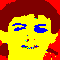

1.502629041671753
Loss = tensor(1.4379, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


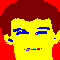

1.437887191772461
Loss = tensor(1.4396, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


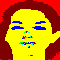

1.439571738243103
Loss = tensor(1.4139, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


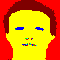

1.4139163494110107
Loss = tensor(1.4512, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


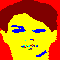

1.4511669874191284
Loss = tensor(1.4150, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


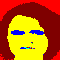

1.415017008781433
Loss = tensor(1.4720, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


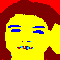

1.472037672996521
Loss = tensor(1.7380, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


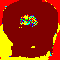

1.7379792928695679
Loss = tensor(1.7510, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


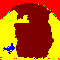

1.7510093450546265
Loss = tensor(1.4343, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


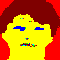

1.4342882633209229
Loss = tensor(1.4810, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


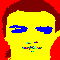

1.481019377708435
Loss = tensor(1.4532, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


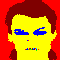

1.4532376527786255
Loss = tensor(1.4750, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


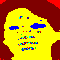

1.475045084953308
Loss = tensor(1.4302, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


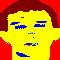

1.4301788806915283
Loss = tensor(1.4582, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


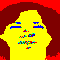

1.458184003829956
Loss = tensor(1.5727, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


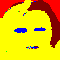

1.5726631879806519
Loss = tensor(1.4286, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


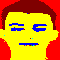

1.4286024570465088
Loss = tensor(1.4614, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


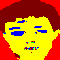

1.4613633155822754
Loss = tensor(1.4639, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


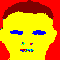

1.463870644569397
Loss = tensor(1.3986, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


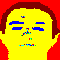

1.3986308574676514
Loss = tensor(1.4887, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


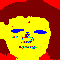

1.4887045621871948
Loss = tensor(1.4716, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


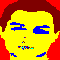

1.471634864807129
Loss = tensor(1.4242, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


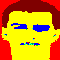

1.4242277145385742
Loss = tensor(1.4863, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


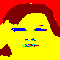

1.4862816333770752
Loss = tensor(1.4941, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


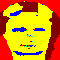

1.4940820932388306
Loss = tensor(1.4564, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


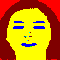

1.456355333328247
Loss = tensor(1.4522, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


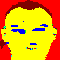

1.4522364139556885
Loss = tensor(1.4514, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


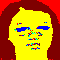

1.451393961906433
Loss = tensor(1.4687, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


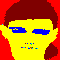

1.4687440395355225
Loss = tensor(1.4678, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


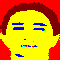

1.467756748199463


In [27]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [29]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/learn_p.npy', boxplot_p)
np.save('metrics/learn_r.npy', boxplot_r)
np.save('metrics/learn_a.npy', boxplot_a)
np.save('metrics/learn_s.npy', boxplot_s)
np.save('metrics/learn_m.npy', boxplot_mi)
np.save('metrics/learn_dice.npy', dice_list)

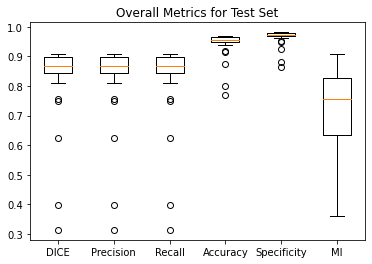

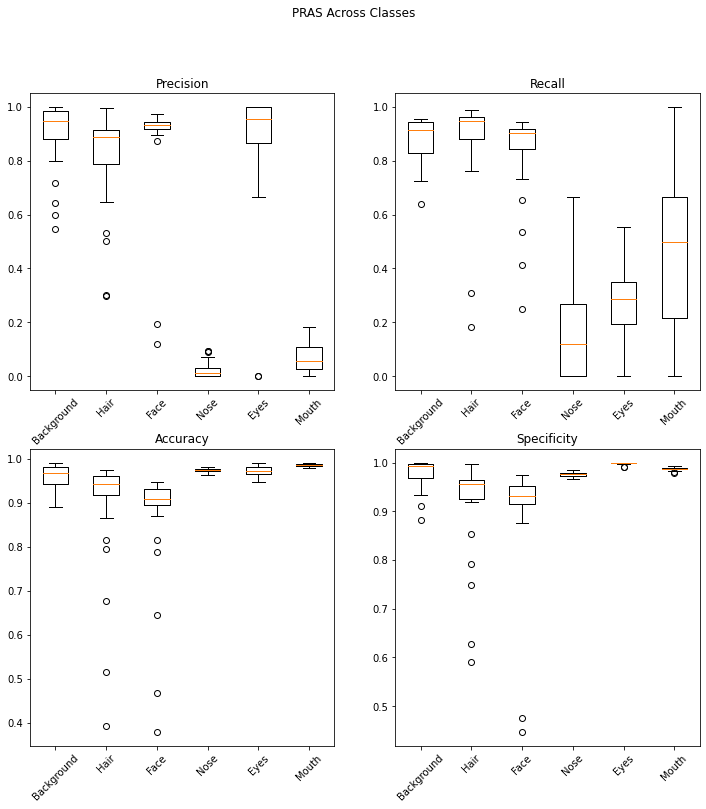

In [30]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1LearnPras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("pras/1LearnPrasClass.png")

In [31]:
np.save('1dice_learn.npy', dice_list)

In [4]:
learn = np.load('dice_learn.npy')
collab = np.load('dice_collabAlt.npy')
global1 = np.load('dice_global.npy')
naive = np.load('dice_naive.npy')
nbhd = np.load('dice_nbhd.npy')
stoch = np.load('dice_stoch.npy')

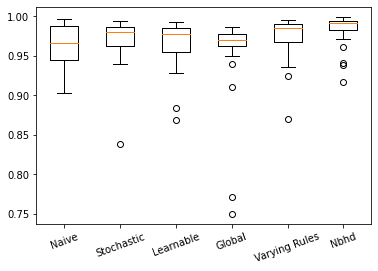

In [18]:
dice_scores = [naive, stoch, learn, global1, collab, nbhd]
plt.boxplot(dice_scores)
plt.xticks([1,2,3,4,5,6],["Naive", "Stochastic", "Learnable", "Global", "Varying Rules", "Nbhd"], rotation=20)
plt.savefig("overall_dice.png")

In [20]:
mean_dice_scores = np.mean(np.array(dice_scores), axis=1)
mean_dice_scores

array([0.96375079, 0.96999221, 0.96604569, 0.95440691, 0.97352972,
       0.98331245])